In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGG16UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16UNet, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        
        # 提取 VGG16 编码器的不同层作为跳跃连接
        self.enc1 = nn.Sequential(*vgg16.features[:4])   # block1_conv2 (64)
        self.enc2 = nn.Sequential(*vgg16.features[4:9])  # block2_conv2 (128)
        self.enc3 = nn.Sequential(*vgg16.features[9:16]) # block3_conv3 (256)
        self.enc4 = nn.Sequential(*vgg16.features[16:23])# block4_conv3 (512)
        self.enc5 = nn.Sequential(*vgg16.features[23:30])# block5_conv3 (512)
        
        # 解码器部分
        self.dec5 = self.decoder_block(512, 512)
        self.dec4 = self.decoder_block(512, 256)
        self.dec3 = self.decoder_block(256, 128)
        self.dec2 = self.decoder_block(128, 64)
        # self.dec1 = self.decoder_block(64, 32)
        self.dec1 = nn.Conv2d(64, 32, kernel_size=1) # 使用1*1的卷积核保持尺寸
        
        # 最终输出层 
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # 编码器部分
        s1 = self.enc1(x)  # (224,224,64)
        s2 = self.enc2(s1) # (112,112,128)
        s3 = self.enc3(s2) # (56,56,256)
        s4 = self.enc4(s3) # (28,28,512)
        s5 = self.enc5(s4) # (14,14,512)
        
        # 解码器部分
        d5 = self.dec5(s5) + s4  # (28,28,512)
        d4 = self.dec4(d5) + s3  # (56,56,256)
        d3 = self.dec3(d4) + s2  # (112,112,128)
        d2 = self.dec2(d3) + s1  # (224,224,64)
        d1 = self.dec1(d2)       # (448,448,32)
        
        # 最终输出
        # output = torch.sigmoid(self.final_conv(d1))
        output = self.final_conv(d1)

        # print("s1:", s1.shape)
        # print("s2:", s2.shape)
        # print("s3:", s3.shape)
        # print("s4:", s4.shape)
        # print("s5:", s5.shape)
        # print("d5:", d5.shape)
        # print("d4:", d4.shape)
        # print("d3:", d3.shape)
        # print("d2:", d2.shape)
        # print("d1:", d1.shape)
        # print("output:", output.shape)
        return output

# 测试网络
if __name__ == "__main__":
    model = VGG16UNet(num_classes=11)
    x = torch.randn(1, 3, 720, 960)  # 测试输入
    output = model(x)
    print(output.shape)  # 应该输出 (1, 11, 224, 224)


torch.Size([1, 11, 720, 960])


In [11]:
# 创建数据集
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
class Camvid(Dataset):
    def __init__(self, root_dir, label_dir, data_dir, transforms4img=transforms.ToTensor()):
        """在此声明class中的全局变量"""
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.data_dir = data_dir
        # image
        self.img_dir = os.path.join(self.root_dir, self.data_dir)
        self.img_path = sorted(os.listdir(self.img_dir)) # sorted()保留顺序
        # label
        self.label_dir = os.path.join(self.root_dir, self.label_dir)
        self.label_path = sorted(os.listdir(self.label_dir))
        self.transforms4data = transforms4img
        # self.transform4label = transforms4label

    def __getitem__(self, idx):
        """
        return: image: Image类型 -> tensor
                label: np.array类型 -> tensor
                transforms.ToTensor()的过程将label/255以得到[0,1]间的scalar
        """
        # image
        image_name = self.img_path[idx]
        # print(self.img_path)
        image_item_path = os.path.join(self.root_dir, self.img_dir, image_name)
        image = Image.open(image_item_path)
        # label
        label_name = self.label_path[idx]
        # print(self.label_path)
        label_item_path = os.path.join(self.root_dir, self.label_dir, label_name)
        label = np.load(label_item_path)

        image = self.transforms4data(image)
        # label = self.transforms4data(label)
        # label = label.numpy()
        label = torch.from_numpy(label).long()  # 转换为 LongTensor（0-31）
        # label = label.unsqueeze(dim=0)
        return image, label
    
    def __len__(self):
        return(len(self.img_path))
    
rootdir = "/home/sugon/zpy/U-NET/U-net/unet_data"
datadir = "train"
labeldir = "train_numpy"
transforms_img = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((128,128))

])
camvid_dataset = Camvid(root_dir=rootdir, label_dir=labeldir, data_dir=datadir, transforms4img=transforms_img)

# test

train_loader = DataLoader(dataset=camvid_dataset, shuffle=True, batch_size=2, drop_last=True, num_workers=0)

for data, label in train_loader:
    # x, label = data
    print(data.shape)
    print(label.shape)
    break


torch.Size([2, 3, 720, 960])
torch.Size([2, 720, 960])


In [ ]:
import torch.optim as optim
from tqdm import tqdm
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0,1,2,3]
model = VGG16UNet(num_classes=1).cuda(device_ids[0])
# model = nn.DataParallel(model, device_ids=device_ids)
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
epochs = 100

for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda(device_ids[0])
        target = target.cuda(device_ids[0])
        # print(data.shape, target.shape)
        optimizer.zero_grad()  # 清空梯度
        output = model(data)  # 前向传播
        loss = criterion(output, target)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
    print(f"Epoch {epoch + 1} finished. Average Loss: {running_loss / len(train_loader):.4f}")

# 模型评估
# model.eval()  # 设置模型为评估模式
# correct = 0
# total = 0
# with torch.no_grad():  # 关闭梯度计算
#     for data, target in test_loader:
#         output = model(data)
#         _, predicted = torch.max(output.data, 1)  # 获取预测结果
#         total += target.size(0)
#         correct += (predicted == target).sum().item()

# accuracy = 100 * correct / total
# print(f"Test Accuracy: {accuracy:.2f}%")

In [25]:
print(label.unique())
model = VGG16UNet(num_classes=11)
print(model(data).shape)
criterion = nn.CrossEntropyLoss()

# 计算损失
loss = criterion(model(data), label)

print(loss.item())  # 输出损失值

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
torch.Size([2, 11, 720, 960])
2.424468994140625


In [ ]:
import torch
torch.cuda.empty_cache()

In [26]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


Total parameters: 24894475


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数
num_epochs = 1000
batch_size = 2
learning_rate = 1e-4
loss_summary = []
accuracy_summary = []
iou_summary = []

# 数据预处理
transforms_img = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((128, 128))
    # transforms.Normalize(mean=[0.2,0.2,0.2],
    #                      std=[0.2,0.2,0.3])
])

# 数据集和数据加载器
rootdir = "/home/sugon/zpy/U-NET/U-net/unet_data"
datadir = "train"
labeldir = "train_numpy"

camvid_dataset = Camvid(root_dir=rootdir, label_dir=labeldir, data_dir=datadir, transforms4img=transforms_img)
# train_loader = DataLoader(dataset=camvid_dataset, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=0)

# 划分训练集和验证集
train_size = int(0.8 * len(camvid_dataset))
val_size = len(camvid_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(camvid_dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=0)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=batch_size, drop_last=True, num_workers=0)

# 初始化模型
model = VGG16UNet(num_classes=11).to(device)
model.load_state_dict(torch.load("/home/sugon/zpy/U-NET/U-net/train_results/vgg16_unet_epoch_99.pth", map_location=device)) # 从60代开始训

# 损失函数和优化器
# criterion = nn.BCELoss()  # 由于最后使用 sigmoid，所以使用 BCELoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# 计算分割准确率
def calculate_accuracy(model, dataloader):
    model.eval()
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)  # [batch, num_classes, H, W]
            preds = torch.argmax(outputs, dim=1)  # [batch, H, W]

            correct_pixels += (preds == labels).sum().item()
            total_pixels += labels.numel()

    return correct_pixels / total_pixels  # 像素级准确率

# IoU
def calculate_iou(model, dataloader, num_classes=11):
    model.eval()
    iou_sum = 0
    num_batches = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            iou = []
            for cls in range(num_classes):
                intersection = ((preds == cls) & (labels == cls)).sum().item()
                union = ((preds == cls) | (labels == cls)).sum().item()
                if union == 0:
                    continue
                iou.append(intersection / union)

            if iou:
                iou_sum += sum(iou) / len(iou)
                num_batches += 1

    return iou_sum / num_batches if num_batches > 0 else 0.0

# 训练循环
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)
        # labels = labels.float()  # 确保标签数据类型匹配
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (batch_idx + 1))
    
    # loss
    train_loss = running_loss / len(train_loader)
    loss_summary.append(running_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")

    
    if epoch%50 == 0:
        # 计算验证准确率
        val_accuracy = calculate_accuracy(model, val_loader)
        traini_accuracy = calculate_accuracy(model, train_loader)
        accuracy_summary.append(val_accuracy)
        

        # 计算 IoU
        val_iou = calculate_iou(model, val_loader)
        iou_summary.append(val_iou)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {traini_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, IoU: {val_iou:.4f}")
        
    # 保存模型
    save_dir = "/home/sugon/zpy/U-NET/U-net/train_results/from100/"
    save_path = os.path.join(save_dir, f"vgg16_unet_epoch_{epoch+1}.pth")
    if (train_loss < loss_summary[-1]) and epoch != 0:
        torch.save(model.state_dict(), save_path)

print("训练完成!")


/tmp/ipykernel_3031745/925570820.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/sugon/zpy/U-NET/U-net/train_results/vgg16_unet_

Epoch [1/1000], Loss: 0.0755
Epoch [1/1000], Loss: 0.0755, Train Accuracy: 0.9823, Validation Accuracy: 0.9801, IoU: 0.8566


Epoch 2/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0512]


Epoch [2/1000], Loss: 0.0512


Epoch 3/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.0434]


Epoch [3/1000], Loss: 0.0434


Epoch 4/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0373]


Epoch [4/1000], Loss: 0.0373


Epoch 5/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0348]


Epoch [5/1000], Loss: 0.0348


Epoch 6/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0646]


Epoch [6/1000], Loss: 0.0646


Epoch 7/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0535]


Epoch [7/1000], Loss: 0.0535


Epoch 8/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0348]


Epoch [8/1000], Loss: 0.0348


Epoch 9/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0307]


Epoch [9/1000], Loss: 0.0307


Epoch 10/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0289]


Epoch [10/1000], Loss: 0.0289


Epoch 11/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.028] 


Epoch [11/1000], Loss: 0.0280


Epoch 12/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0276]


Epoch [12/1000], Loss: 0.0276


Epoch 13/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0277]


Epoch [13/1000], Loss: 0.0277


Epoch 14/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0284]


Epoch [14/1000], Loss: 0.0284


Epoch 15/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0285]


Epoch [15/1000], Loss: 0.0285


Epoch 16/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0287]


Epoch [16/1000], Loss: 0.0287


Epoch 17/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0285]


Epoch [17/1000], Loss: 0.0285


Epoch 18/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.028] 


Epoch [18/1000], Loss: 0.0280


Epoch 19/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0283]


Epoch [19/1000], Loss: 0.0283


Epoch 20/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.028] 


Epoch [20/1000], Loss: 0.0280


Epoch 21/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0281]


Epoch [21/1000], Loss: 0.0281


Epoch 22/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0273]


Epoch [22/1000], Loss: 0.0273


Epoch 23/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0265]


Epoch [23/1000], Loss: 0.0265


Epoch 24/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.0262]


Epoch [24/1000], Loss: 0.0262


Epoch 25/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.028] 


Epoch [25/1000], Loss: 0.0280


Epoch 26/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.0325]


Epoch [26/1000], Loss: 0.0325


Epoch 27/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0284]


Epoch [27/1000], Loss: 0.0284


Epoch 28/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0255]


Epoch [28/1000], Loss: 0.0255


Epoch 29/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0246]


Epoch [29/1000], Loss: 0.0246


Epoch 30/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0249]


Epoch [30/1000], Loss: 0.0249


Epoch 31/1000: 100%|██████████| 216/216 [02:15<00:00,  1.60it/s, loss=0.0253]


Epoch [31/1000], Loss: 0.0253


Epoch 32/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.026] 


Epoch [32/1000], Loss: 0.0260


Epoch 33/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0265]


Epoch [33/1000], Loss: 0.0265


Epoch 34/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0286]


Epoch [34/1000], Loss: 0.0286


Epoch 35/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.133]


Epoch [35/1000], Loss: 0.1331


Epoch 36/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0361]


Epoch [36/1000], Loss: 0.0361


Epoch 37/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0266]


Epoch [37/1000], Loss: 0.0266


Epoch 38/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0234]


Epoch [38/1000], Loss: 0.0234


Epoch 39/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0218]


Epoch [39/1000], Loss: 0.0218


Epoch 40/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0208]


Epoch [40/1000], Loss: 0.0208


Epoch 41/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0204]


Epoch [41/1000], Loss: 0.0204


Epoch 42/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0203]


Epoch [42/1000], Loss: 0.0203


Epoch 43/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0203]


Epoch [43/1000], Loss: 0.0203


Epoch 44/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0208]


Epoch [44/1000], Loss: 0.0208


Epoch 45/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0211]


Epoch [45/1000], Loss: 0.0211


Epoch 46/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0212]


Epoch [46/1000], Loss: 0.0212


Epoch 47/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0214]


Epoch [47/1000], Loss: 0.0214


Epoch 48/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0214]


Epoch [48/1000], Loss: 0.0214


Epoch 49/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0216]


Epoch [49/1000], Loss: 0.0216


Epoch 50/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0217]


Epoch [50/1000], Loss: 0.0217


Epoch 51/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.022] 


Epoch [51/1000], Loss: 0.0220
Epoch [51/1000], Loss: 0.0220, Train Accuracy: 0.9904, Validation Accuracy: 0.9762, IoU: 0.8422


Epoch 52/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0227]


Epoch [52/1000], Loss: 0.0227


Epoch 53/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0221]


Epoch [53/1000], Loss: 0.0221


Epoch 54/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0219]


Epoch [54/1000], Loss: 0.0219


Epoch 55/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0219]


Epoch [55/1000], Loss: 0.0219


Epoch 56/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.022] 


Epoch [56/1000], Loss: 0.0220


Epoch 57/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0224]


Epoch [57/1000], Loss: 0.0224


Epoch 58/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0217]


Epoch [58/1000], Loss: 0.0217


Epoch 59/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.021] 


Epoch [59/1000], Loss: 0.0210


Epoch 60/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0207]


Epoch [60/1000], Loss: 0.0207


Epoch 61/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0209]


Epoch [61/1000], Loss: 0.0209


Epoch 62/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0208]


Epoch [62/1000], Loss: 0.0208


Epoch 63/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0209]


Epoch [63/1000], Loss: 0.0209


Epoch 64/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0204]


Epoch [64/1000], Loss: 0.0204


Epoch 65/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.027] 


Epoch [65/1000], Loss: 0.0270


Epoch 66/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0258]


Epoch [66/1000], Loss: 0.0258


Epoch 67/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0208]


Epoch [67/1000], Loss: 0.0208


Epoch 68/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0191]


Epoch [68/1000], Loss: 0.0191


Epoch 69/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0187]


Epoch [69/1000], Loss: 0.0187


Epoch 70/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0188]


Epoch [70/1000], Loss: 0.0188


Epoch 71/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0189]


Epoch [71/1000], Loss: 0.0189


Epoch 72/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0194]


Epoch [72/1000], Loss: 0.0194


Epoch 73/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0195]


Epoch [73/1000], Loss: 0.0195


Epoch 74/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0196]


Epoch [74/1000], Loss: 0.0196


Epoch 75/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0191]


Epoch [75/1000], Loss: 0.0191


Epoch 76/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0189]


Epoch [76/1000], Loss: 0.0189


Epoch 77/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0192]


Epoch [77/1000], Loss: 0.0192


Epoch 78/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0191]


Epoch [78/1000], Loss: 0.0191


Epoch 79/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0189]


Epoch [79/1000], Loss: 0.0189


Epoch 80/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0184]


Epoch [80/1000], Loss: 0.0184


Epoch 81/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0183]


Epoch [81/1000], Loss: 0.0183


Epoch 82/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0186]


Epoch [82/1000], Loss: 0.0186


Epoch 83/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0185]


Epoch [83/1000], Loss: 0.0185


Epoch 84/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0187]


Epoch [84/1000], Loss: 0.0187


Epoch 85/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0208]


Epoch [85/1000], Loss: 0.0208


Epoch 86/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0193]


Epoch [86/1000], Loss: 0.0193


Epoch 87/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0175]


Epoch [87/1000], Loss: 0.0175


Epoch 88/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.017] 


Epoch [88/1000], Loss: 0.0170


Epoch 89/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0169]


Epoch [89/1000], Loss: 0.0169


Epoch 90/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0172]


Epoch [90/1000], Loss: 0.0172


Epoch 91/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0175]


Epoch [91/1000], Loss: 0.0175


Epoch 92/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0177]


Epoch [92/1000], Loss: 0.0177


Epoch 93/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0174]


Epoch [93/1000], Loss: 0.0174


Epoch 94/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0169]


Epoch [94/1000], Loss: 0.0169


Epoch 95/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0929]


Epoch [95/1000], Loss: 0.0929


Epoch 96/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0412]


Epoch [96/1000], Loss: 0.0412


Epoch 97/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0225]


Epoch [97/1000], Loss: 0.0225


Epoch 98/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.0185]


Epoch [98/1000], Loss: 0.0185


Epoch 99/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0166]


Epoch [99/1000], Loss: 0.0166


Epoch 100/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.0156]


Epoch [100/1000], Loss: 0.0156


Epoch 101/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0148]


Epoch [101/1000], Loss: 0.0148
Epoch [101/1000], Loss: 0.0148, Train Accuracy: 0.9940, Validation Accuracy: 0.9735, IoU: 0.8158


Epoch 102/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0143]


Epoch [102/1000], Loss: 0.0143


Epoch 103/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.014] 


Epoch [103/1000], Loss: 0.0140


Epoch 104/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0138]


Epoch [104/1000], Loss: 0.0138


Epoch 105/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0141]


Epoch [105/1000], Loss: 0.0141


Epoch 106/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0144]


Epoch [106/1000], Loss: 0.0144


Epoch 107/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0149]


Epoch [107/1000], Loss: 0.0149


Epoch 108/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0151]


Epoch [108/1000], Loss: 0.0151


Epoch 109/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0153]


Epoch [109/1000], Loss: 0.0153


Epoch 110/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0151]


Epoch [110/1000], Loss: 0.0151


Epoch 111/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0148]


Epoch [111/1000], Loss: 0.0148


Epoch 112/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.015] 


Epoch [112/1000], Loss: 0.0150


Epoch 113/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0159]


Epoch [113/1000], Loss: 0.0159


Epoch 114/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0165]


Epoch [114/1000], Loss: 0.0165


Epoch 115/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.016] 


Epoch [115/1000], Loss: 0.0160


Epoch 116/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0155]


Epoch [116/1000], Loss: 0.0155


Epoch 117/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0153]


Epoch [117/1000], Loss: 0.0153


Epoch 118/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0151]


Epoch [118/1000], Loss: 0.0151


Epoch 119/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0152]


Epoch [119/1000], Loss: 0.0152


Epoch 120/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0155]


Epoch [120/1000], Loss: 0.0155


Epoch 121/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0153]


Epoch [121/1000], Loss: 0.0153


Epoch 122/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0156]


Epoch [122/1000], Loss: 0.0156


Epoch 123/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0157]


Epoch [123/1000], Loss: 0.0157


Epoch 124/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0156]


Epoch [124/1000], Loss: 0.0156


Epoch 125/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0154]


Epoch [125/1000], Loss: 0.0154


Epoch 126/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0154]


Epoch [126/1000], Loss: 0.0154


Epoch 127/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0156]


Epoch [127/1000], Loss: 0.0156


Epoch 128/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0157]


Epoch [128/1000], Loss: 0.0157


Epoch 129/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0152]


Epoch [129/1000], Loss: 0.0152


Epoch 130/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0146]


Epoch [130/1000], Loss: 0.0146


Epoch 131/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0147]


Epoch [131/1000], Loss: 0.0147


Epoch 132/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0145]


Epoch [132/1000], Loss: 0.0145


Epoch 133/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0146]


Epoch [133/1000], Loss: 0.0146


Epoch 134/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0147]


Epoch [134/1000], Loss: 0.0147


Epoch 135/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0145]


Epoch [135/1000], Loss: 0.0145


Epoch 136/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0145]


Epoch [136/1000], Loss: 0.0145


Epoch 137/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0148]


Epoch [137/1000], Loss: 0.0148


Epoch 138/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0146]


Epoch [138/1000], Loss: 0.0146


Epoch 139/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0148]


Epoch [139/1000], Loss: 0.0148


Epoch 140/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0144]


Epoch [140/1000], Loss: 0.0144


Epoch 141/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0141]


Epoch [141/1000], Loss: 0.0141


Epoch 142/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0138]


Epoch [142/1000], Loss: 0.0138


Epoch 143/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0139]


Epoch [143/1000], Loss: 0.0139


Epoch 144/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0139]


Epoch [144/1000], Loss: 0.0139


Epoch 145/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0141]


Epoch [145/1000], Loss: 0.0141


Epoch 146/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0137]


Epoch [146/1000], Loss: 0.0137


Epoch 147/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0138]


Epoch [147/1000], Loss: 0.0138


Epoch 148/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0138]


Epoch [148/1000], Loss: 0.0138


Epoch 149/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0135]


Epoch [149/1000], Loss: 0.0135


Epoch 150/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0136]


Epoch [150/1000], Loss: 0.0136


Epoch 151/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0137]


Epoch [151/1000], Loss: 0.0137
Epoch [151/1000], Loss: 0.0137, Train Accuracy: 0.9942, Validation Accuracy: 0.9715, IoU: 0.8039


Epoch 152/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.014] 


Epoch [152/1000], Loss: 0.0140


Epoch 153/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0137]


Epoch [153/1000], Loss: 0.0137


Epoch 154/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0134]


Epoch [154/1000], Loss: 0.0134


Epoch 155/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0131]


Epoch [155/1000], Loss: 0.0131


Epoch 156/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.013] 


Epoch [156/1000], Loss: 0.0130


Epoch 157/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.013] 


Epoch [157/1000], Loss: 0.0130


Epoch 158/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.013] 


Epoch [158/1000], Loss: 0.0130


Epoch 159/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0132]


Epoch [159/1000], Loss: 0.0132


Epoch 160/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0137]


Epoch [160/1000], Loss: 0.0137


Epoch 161/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0134]


Epoch [161/1000], Loss: 0.0134


Epoch 162/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0605]


Epoch [162/1000], Loss: 0.0605


Epoch 163/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0767]


Epoch [163/1000], Loss: 0.0767


Epoch 164/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0226]


Epoch [164/1000], Loss: 0.0226


Epoch 165/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0168]


Epoch [165/1000], Loss: 0.0168


Epoch 166/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0146]


Epoch [166/1000], Loss: 0.0146


Epoch 167/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0133]


Epoch [167/1000], Loss: 0.0133


Epoch 168/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0124]


Epoch [168/1000], Loss: 0.0124


Epoch 169/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0118]


Epoch [169/1000], Loss: 0.0118


Epoch 170/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0114]


Epoch [170/1000], Loss: 0.0114


Epoch 171/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.011] 


Epoch [171/1000], Loss: 0.0110


Epoch 172/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0108]


Epoch [172/1000], Loss: 0.0108


Epoch 173/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0106]


Epoch [173/1000], Loss: 0.0106


Epoch 174/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0105]


Epoch [174/1000], Loss: 0.0105


Epoch 175/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0105]


Epoch [175/1000], Loss: 0.0105


Epoch 176/1000: 100%|██████████| 216/216 [02:15<00:00,  1.59it/s, loss=0.0109]


Epoch [176/1000], Loss: 0.0109


Epoch 177/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0113]


Epoch [177/1000], Loss: 0.0113


Epoch 178/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0113]


Epoch [178/1000], Loss: 0.0113


Epoch 179/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0112]


Epoch [179/1000], Loss: 0.0112


Epoch 180/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0113]


Epoch [180/1000], Loss: 0.0113


Epoch 181/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0114]


Epoch [181/1000], Loss: 0.0114


Epoch 182/1000: 100%|██████████| 216/216 [02:16<00:00,  1.59it/s, loss=0.0116]


Epoch [182/1000], Loss: 0.0116


Epoch 183/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0116]


Epoch [183/1000], Loss: 0.0116


Epoch 184/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0116]


Epoch [184/1000], Loss: 0.0116


Epoch 185/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0119]


Epoch [185/1000], Loss: 0.0119


Epoch 186/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0119]


Epoch [186/1000], Loss: 0.0119


Epoch 187/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.0118]


Epoch [187/1000], Loss: 0.0118


Epoch 188/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0118]


Epoch [188/1000], Loss: 0.0118


Epoch 189/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0121]


Epoch [189/1000], Loss: 0.0121


Epoch 190/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.0122]


Epoch [190/1000], Loss: 0.0122


Epoch 191/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0121]


Epoch [191/1000], Loss: 0.0121


Epoch 192/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0148]


Epoch [192/1000], Loss: 0.0148


Epoch 193/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0142]


Epoch [193/1000], Loss: 0.0142


Epoch 194/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0125]


Epoch [194/1000], Loss: 0.0125


Epoch 195/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.0115]


Epoch [195/1000], Loss: 0.0115


Epoch 196/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.011] 


Epoch [196/1000], Loss: 0.0110


Epoch 197/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.011] 


Epoch [197/1000], Loss: 0.0110


Epoch 198/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0113]


Epoch [198/1000], Loss: 0.0113


Epoch 199/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0116]


Epoch [199/1000], Loss: 0.0116


Epoch 200/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.0116]


Epoch [200/1000], Loss: 0.0116


Epoch 201/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0118]


Epoch [201/1000], Loss: 0.0118
Epoch [201/1000], Loss: 0.0118, Train Accuracy: 0.9950, Validation Accuracy: 0.9705, IoU: 0.8026


Epoch 202/1000: 100%|██████████| 216/216 [02:16<00:00,  1.58it/s, loss=0.0118]


Epoch [202/1000], Loss: 0.0118


Epoch 203/1000: 100%|██████████| 216/216 [02:17<00:00,  1.58it/s, loss=0.0126]


Epoch [203/1000], Loss: 0.0126


Epoch 204/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0122]


Epoch [204/1000], Loss: 0.0122


Epoch 205/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0115]


Epoch [205/1000], Loss: 0.0115


Epoch 206/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0112]


Epoch [206/1000], Loss: 0.0112


Epoch 207/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0111]


Epoch [207/1000], Loss: 0.0111


Epoch 208/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0111]


Epoch [208/1000], Loss: 0.0111


Epoch 209/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0114]


Epoch [209/1000], Loss: 0.0114


Epoch 210/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0116]


Epoch [210/1000], Loss: 0.0116


Epoch 211/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0116]


Epoch [211/1000], Loss: 0.0116


Epoch 212/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0117]


Epoch [212/1000], Loss: 0.0117


Epoch 213/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0114]


Epoch [213/1000], Loss: 0.0114


Epoch 214/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0113]


Epoch [214/1000], Loss: 0.0113


Epoch 215/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0113]


Epoch [215/1000], Loss: 0.0113


Epoch 216/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0112]


Epoch [216/1000], Loss: 0.0112


Epoch 217/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0113]


Epoch [217/1000], Loss: 0.0113


Epoch 218/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0111]


Epoch [218/1000], Loss: 0.0111


Epoch 219/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0109]


Epoch [219/1000], Loss: 0.0109


Epoch 220/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0859]


Epoch [220/1000], Loss: 0.0859


Epoch 221/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.024] 


Epoch [221/1000], Loss: 0.0240


Epoch 222/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0157]


Epoch [222/1000], Loss: 0.0157


Epoch 223/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0131]


Epoch [223/1000], Loss: 0.0131


Epoch 224/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0117]


Epoch [224/1000], Loss: 0.0117


Epoch 225/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0109]


Epoch [225/1000], Loss: 0.0109


Epoch 226/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0103]


Epoch [226/1000], Loss: 0.0103


Epoch 227/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00983]


Epoch [227/1000], Loss: 0.0098


Epoch 228/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0095] 


Epoch [228/1000], Loss: 0.0095


Epoch 229/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00925]


Epoch [229/1000], Loss: 0.0093


Epoch 230/1000: 100%|██████████| 216/216 [02:18<00:00,  1.57it/s, loss=0.00909]


Epoch [230/1000], Loss: 0.0091


Epoch 231/1000: 100%|██████████| 216/216 [02:18<00:00,  1.57it/s, loss=0.00902]


Epoch [231/1000], Loss: 0.0090


Epoch 232/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00922]


Epoch [232/1000], Loss: 0.0092


Epoch 233/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00945]


Epoch [233/1000], Loss: 0.0095


Epoch 234/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00962]


Epoch [234/1000], Loss: 0.0096


Epoch 235/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00979]


Epoch [235/1000], Loss: 0.0098


Epoch 236/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00983]


Epoch [236/1000], Loss: 0.0098


Epoch 237/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00993]


Epoch [237/1000], Loss: 0.0099


Epoch 238/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00995]


Epoch [238/1000], Loss: 0.0100


Epoch 239/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00997]


Epoch [239/1000], Loss: 0.0100


Epoch 240/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0101]


Epoch [240/1000], Loss: 0.0101


Epoch 241/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0101]


Epoch [241/1000], Loss: 0.0101


Epoch 242/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0102]


Epoch [242/1000], Loss: 0.0102


Epoch 243/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0102]


Epoch [243/1000], Loss: 0.0102


Epoch 244/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0102]


Epoch [244/1000], Loss: 0.0102


Epoch 245/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0103]


Epoch [245/1000], Loss: 0.0103


Epoch 246/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0105]


Epoch [246/1000], Loss: 0.0105


Epoch 247/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0104]


Epoch [247/1000], Loss: 0.0104


Epoch 248/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0104]


Epoch [248/1000], Loss: 0.0104


Epoch 249/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0102]


Epoch [249/1000], Loss: 0.0102


Epoch 250/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0102]


Epoch [250/1000], Loss: 0.0102


Epoch 251/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0106]


Epoch [251/1000], Loss: 0.0106
Epoch [251/1000], Loss: 0.0106, Train Accuracy: 0.9953, Validation Accuracy: 0.9695, IoU: 0.7953


Epoch 252/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0109]


Epoch [252/1000], Loss: 0.0109


Epoch 253/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0106]


Epoch [253/1000], Loss: 0.0106


Epoch 254/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0108]


Epoch [254/1000], Loss: 0.0108


Epoch 255/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0103]


Epoch [255/1000], Loss: 0.0103


Epoch 256/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0101] 


Epoch [256/1000], Loss: 0.0101


Epoch 257/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00988]


Epoch [257/1000], Loss: 0.0099


Epoch 258/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.01]   


Epoch [258/1000], Loss: 0.0100


Epoch 259/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0109]


Epoch [259/1000], Loss: 0.0109


Epoch 260/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0108]


Epoch [260/1000], Loss: 0.0108


Epoch 261/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0107]


Epoch [261/1000], Loss: 0.0107


Epoch 262/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0104]


Epoch [262/1000], Loss: 0.0104


Epoch 263/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0108]


Epoch [263/1000], Loss: 0.0108


Epoch 264/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0104]


Epoch [264/1000], Loss: 0.0104


Epoch 265/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.0099] 


Epoch [265/1000], Loss: 0.0099


Epoch 266/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00962]


Epoch [266/1000], Loss: 0.0096


Epoch 267/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00952]


Epoch [267/1000], Loss: 0.0095


Epoch 268/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00955]


Epoch [268/1000], Loss: 0.0096


Epoch 269/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00976]


Epoch [269/1000], Loss: 0.0098


Epoch 270/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00979]


Epoch [270/1000], Loss: 0.0098


Epoch 271/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00998]


Epoch [271/1000], Loss: 0.0100


Epoch 272/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00996]


Epoch [272/1000], Loss: 0.0100


Epoch 273/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00977]


Epoch [273/1000], Loss: 0.0098


Epoch 274/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0097] 


Epoch [274/1000], Loss: 0.0097


Epoch 275/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00949]


Epoch [275/1000], Loss: 0.0095


Epoch 276/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00947]


Epoch [276/1000], Loss: 0.0095


Epoch 277/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0096] 


Epoch [277/1000], Loss: 0.0096


Epoch 278/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00956]


Epoch [278/1000], Loss: 0.0096


Epoch 279/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.00952]


Epoch [279/1000], Loss: 0.0095


Epoch 280/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00966]


Epoch [280/1000], Loss: 0.0097


Epoch 281/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00972]


Epoch [281/1000], Loss: 0.0097


Epoch 282/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00978]


Epoch [282/1000], Loss: 0.0098


Epoch 283/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00954]


Epoch [283/1000], Loss: 0.0095


Epoch 284/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0095] 


Epoch [284/1000], Loss: 0.0095


Epoch 285/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00979]


Epoch [285/1000], Loss: 0.0098


Epoch 286/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00975]


Epoch [286/1000], Loss: 0.0098


Epoch 287/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00942]


Epoch [287/1000], Loss: 0.0094


Epoch 288/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00904]


Epoch [288/1000], Loss: 0.0090


Epoch 289/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00917]


Epoch [289/1000], Loss: 0.0092


Epoch 290/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00937]


Epoch [290/1000], Loss: 0.0094


Epoch 291/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00942]


Epoch [291/1000], Loss: 0.0094


Epoch 292/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00936]


Epoch [292/1000], Loss: 0.0094


Epoch 293/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00917]


Epoch [293/1000], Loss: 0.0092


Epoch 294/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0089] 


Epoch [294/1000], Loss: 0.0089


Epoch 295/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.009]  


Epoch [295/1000], Loss: 0.0090


Epoch 296/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00909]


Epoch [296/1000], Loss: 0.0091


Epoch 297/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00901]


Epoch [297/1000], Loss: 0.0090


Epoch 298/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00891]


Epoch [298/1000], Loss: 0.0089


Epoch 299/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00879]


Epoch [299/1000], Loss: 0.0088


Epoch 300/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.064] 


Epoch [300/1000], Loss: 0.0640


Epoch 301/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0292]


Epoch [301/1000], Loss: 0.0292
Epoch [301/1000], Loss: 0.0292, Train Accuracy: 0.9929, Validation Accuracy: 0.9681, IoU: 0.7877


Epoch 302/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.0155]


Epoch [302/1000], Loss: 0.0155


Epoch 303/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0124]


Epoch [303/1000], Loss: 0.0124


Epoch 304/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0108]


Epoch [304/1000], Loss: 0.0108


Epoch 305/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00972]


Epoch [305/1000], Loss: 0.0097


Epoch 306/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00901]


Epoch [306/1000], Loss: 0.0090


Epoch 307/1000: 100%|██████████| 216/216 [02:17<00:00,  1.57it/s, loss=0.00846]


Epoch [307/1000], Loss: 0.0085


Epoch 308/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00806]


Epoch [308/1000], Loss: 0.0081


Epoch 309/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00775]


Epoch [309/1000], Loss: 0.0077


Epoch 310/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00753]


Epoch [310/1000], Loss: 0.0075


Epoch 311/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00739]


Epoch [311/1000], Loss: 0.0074


Epoch 312/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00736]


Epoch [312/1000], Loss: 0.0074


Epoch 313/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00745]


Epoch [313/1000], Loss: 0.0075


Epoch 314/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0076] 


Epoch [314/1000], Loss: 0.0076


Epoch 315/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00776]


Epoch [315/1000], Loss: 0.0078


Epoch 316/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00803]


Epoch [316/1000], Loss: 0.0080


Epoch 317/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.00847]


Epoch [317/1000], Loss: 0.0085


Epoch 318/1000: 100%|██████████| 216/216 [02:19<00:00,  1.54it/s, loss=0.00827]


Epoch [318/1000], Loss: 0.0083


Epoch 319/1000: 100%|██████████| 216/216 [02:20<00:00,  1.54it/s, loss=0.00812]


Epoch [319/1000], Loss: 0.0081


Epoch 320/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00813]


Epoch [320/1000], Loss: 0.0081


Epoch 321/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.00826]


Epoch [321/1000], Loss: 0.0083


Epoch 322/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.00834]


Epoch [322/1000], Loss: 0.0083


Epoch 323/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.0083] 


Epoch [323/1000], Loss: 0.0083


Epoch 324/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.0084] 


Epoch [324/1000], Loss: 0.0084


Epoch 325/1000: 100%|██████████| 216/216 [02:18<00:00,  1.56it/s, loss=0.00843]


Epoch [325/1000], Loss: 0.0084


Epoch 326/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.00858]


Epoch [326/1000], Loss: 0.0086


Epoch 327/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.00843]


Epoch [327/1000], Loss: 0.0084


Epoch 328/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.00841]


Epoch [328/1000], Loss: 0.0084


Epoch 329/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.0083] 


Epoch [329/1000], Loss: 0.0083


Epoch 330/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.00828]


Epoch [330/1000], Loss: 0.0083


Epoch 331/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.0084] 


Epoch [331/1000], Loss: 0.0084


Epoch 332/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.00835]


Epoch [332/1000], Loss: 0.0083


Epoch 333/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.00843]


Epoch [333/1000], Loss: 0.0084


Epoch 334/1000: 100%|██████████| 216/216 [02:19<00:00,  1.55it/s, loss=0.0085] 


Epoch [334/1000], Loss: 0.0085


Epoch 335/1000: 100%|██████████| 216/216 [02:20<00:00,  1.54it/s, loss=0.00842]


Epoch [335/1000], Loss: 0.0084


Epoch 336/1000: 100%|██████████| 216/216 [02:21<00:00,  1.53it/s, loss=0.00835]


Epoch [336/1000], Loss: 0.0083


Epoch 337/1000: 100%|██████████| 216/216 [02:20<00:00,  1.54it/s, loss=0.00836]


Epoch [337/1000], Loss: 0.0084


Epoch 338/1000: 100%|██████████| 216/216 [02:20<00:00,  1.54it/s, loss=0.0083] 


Epoch [338/1000], Loss: 0.0083


Epoch 339/1000: 100%|██████████| 216/216 [02:20<00:00,  1.53it/s, loss=0.00824]


Epoch [339/1000], Loss: 0.0082


Epoch 340/1000: 100%|██████████| 216/216 [02:21<00:00,  1.53it/s, loss=0.00833]


Epoch [340/1000], Loss: 0.0083


Epoch 341/1000: 100%|██████████| 216/216 [02:21<00:00,  1.53it/s, loss=0.0117] 


Epoch [341/1000], Loss: 0.0117


Epoch 342/1000: 100%|██████████| 216/216 [02:19<00:00,  1.54it/s, loss=0.0996]


Epoch [342/1000], Loss: 0.0996


Epoch 343/1000: 100%|██████████| 216/216 [02:20<00:00,  1.54it/s, loss=0.0228]


Epoch [343/1000], Loss: 0.0228


Epoch 344/1000: 100%|██████████| 216/216 [02:20<00:00,  1.54it/s, loss=0.0153]


Epoch [344/1000], Loss: 0.0153


Epoch 345/1000: 100%|██████████| 216/216 [02:22<00:00,  1.52it/s, loss=0.0125]


Epoch [345/1000], Loss: 0.0125


Epoch 346/1000: 100%|██████████| 216/216 [02:21<00:00,  1.53it/s, loss=0.0109]


Epoch [346/1000], Loss: 0.0109


Epoch 347/1000: 100%|██████████| 216/216 [02:21<00:00,  1.53it/s, loss=0.00984]


Epoch [347/1000], Loss: 0.0098


Epoch 348/1000: 100%|██████████| 216/216 [02:22<00:00,  1.52it/s, loss=0.00904]


Epoch [348/1000], Loss: 0.0090


Epoch 349/1000: 100%|██████████| 216/216 [02:21<00:00,  1.53it/s, loss=0.00842]


Epoch [349/1000], Loss: 0.0084


Epoch 350/1000: 100%|██████████| 216/216 [02:21<00:00,  1.53it/s, loss=0.00793]


Epoch [350/1000], Loss: 0.0079


Epoch 351/1000: 100%|██████████| 216/216 [02:21<00:00,  1.53it/s, loss=0.00755]


Epoch [351/1000], Loss: 0.0075
Epoch [351/1000], Loss: 0.0075, Train Accuracy: 0.9966, Validation Accuracy: 0.9681, IoU: 0.7920


Epoch 352/1000: 100%|██████████| 216/216 [02:21<00:00,  1.53it/s, loss=0.00724]


Epoch [352/1000], Loss: 0.0072


Epoch 353/1000: 100%|██████████| 216/216 [02:24<00:00,  1.50it/s, loss=0.007]  


Epoch [353/1000], Loss: 0.0070


Epoch 354/1000: 100%|██████████| 216/216 [02:22<00:00,  1.52it/s, loss=0.00685]


Epoch [354/1000], Loss: 0.0069


Epoch 355/1000: 100%|██████████| 216/216 [02:21<00:00,  1.52it/s, loss=0.00682]


Epoch [355/1000], Loss: 0.0068


Epoch 356/1000: 100%|██████████| 216/216 [02:21<00:00,  1.53it/s, loss=0.00684]


Epoch [356/1000], Loss: 0.0068


Epoch 357/1000: 100%|██████████| 216/216 [02:23<00:00,  1.51it/s, loss=0.00699]


Epoch [357/1000], Loss: 0.0070


Epoch 358/1000: 100%|██████████| 216/216 [02:23<00:00,  1.51it/s, loss=0.0072] 


Epoch [358/1000], Loss: 0.0072


Epoch 359/1000: 100%|██████████| 216/216 [02:22<00:00,  1.52it/s, loss=0.00747]


Epoch [359/1000], Loss: 0.0075


Epoch 360/1000: 100%|██████████| 216/216 [02:22<00:00,  1.52it/s, loss=0.00746]


Epoch [360/1000], Loss: 0.0075


Epoch 361/1000: 100%|██████████| 216/216 [02:23<00:00,  1.51it/s, loss=0.0075] 


Epoch [361/1000], Loss: 0.0075


Epoch 362/1000: 100%|██████████| 216/216 [02:23<00:00,  1.50it/s, loss=0.00742]


Epoch [362/1000], Loss: 0.0074


Epoch 363/1000: 100%|██████████| 216/216 [02:22<00:00,  1.52it/s, loss=0.00764]


Epoch [363/1000], Loss: 0.0076


Epoch 364/1000: 100%|██████████| 216/216 [02:24<00:00,  1.50it/s, loss=0.00757]


Epoch [364/1000], Loss: 0.0076


Epoch 365/1000: 100%|██████████| 216/216 [02:24<00:00,  1.49it/s, loss=0.00743]


Epoch [365/1000], Loss: 0.0074


Epoch 366/1000: 100%|██████████| 216/216 [02:23<00:00,  1.50it/s, loss=0.00733]


Epoch [366/1000], Loss: 0.0073


Epoch 367/1000: 100%|██████████| 216/216 [02:22<00:00,  1.52it/s, loss=0.00744]


Epoch [367/1000], Loss: 0.0074


Epoch 368/1000: 100%|██████████| 216/216 [02:22<00:00,  1.52it/s, loss=0.00772]


Epoch [368/1000], Loss: 0.0077


Epoch 369/1000: 100%|██████████| 216/216 [02:23<00:00,  1.51it/s, loss=0.00791]


Epoch [369/1000], Loss: 0.0079


Epoch 370/1000: 100%|██████████| 216/216 [02:22<00:00,  1.51it/s, loss=0.00822]


Epoch [370/1000], Loss: 0.0082


Epoch 371/1000: 100%|██████████| 216/216 [02:23<00:00,  1.51it/s, loss=0.00802]


Epoch [371/1000], Loss: 0.0080


Epoch 372/1000: 100%|██████████| 216/216 [02:23<00:00,  1.50it/s, loss=0.00795]


Epoch [372/1000], Loss: 0.0080


Epoch 373/1000: 100%|██████████| 216/216 [02:23<00:00,  1.51it/s, loss=0.00764]


Epoch [373/1000], Loss: 0.0076


Epoch 374/1000: 100%|██████████| 216/216 [02:22<00:00,  1.51it/s, loss=0.00776]


Epoch [374/1000], Loss: 0.0078


Epoch 375/1000:  53%|█████▎    | 115/216 [01:15<01:06,  1.51it/s, loss=0.00768]


KeyboardInterrupt: 

['0001TP_006690.png', '0001TP_006720.png', '0001TP_006750.png', '0001TP_006780.png', '0001TP_006810.png', '0001TP_006840.png', '0001TP_006870.png', '0001TP_006900.png', '0001TP_006930.png', '0001TP_006960.png', '0001TP_006990.png', '0001TP_007020.png', '0001TP_007050.png', '0001TP_007080.png', '0001TP_007110.png', '0001TP_007140.png', '0001TP_007170.png', '0001TP_007200.png', '0001TP_007230.png', '0001TP_007260.png', '0001TP_007290.png', '0001TP_007320.png', '0001TP_007350.png', '0001TP_007380.png', '0001TP_007410.png', '0001TP_007440.png', '0001TP_007470.png', '0001TP_007500.png', '0001TP_007530.png', '0001TP_007560.png', '0001TP_007590.png', '0001TP_007620.png', '0001TP_007650.png', '0001TP_007680.png', '0001TP_007710.png', '0001TP_007740.png', '0001TP_007770.png', '0001TP_007800.png', '0001TP_007830.png', '0001TP_007860.png', '0001TP_007890.png', '0001TP_007920.png', '0001TP_007950.png', '0001TP_007980.png', '0001TP_008010.png', '0001TP_008040.png', '0001TP_008070.png', '0001TP_0081

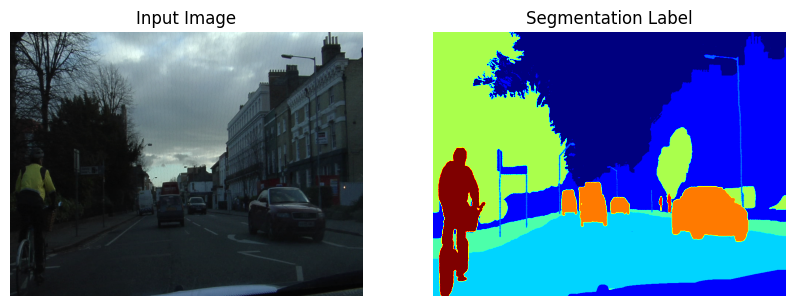

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# 选择一个索引进行可视化
idx = 24  # 你可以修改这个索引

# 获取数据
image, label = camvid_dataset[idx]

# 转换回 numpy 格式以便于可视化
image_np = image.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
label_np = label.numpy()  # [H, W] 或者 [1, H, W]

# 画图
plt.figure(figsize=(10, 5))

# 显示原始图像
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Input Image")
plt.axis("off")

# 显示标签
plt.subplot(1, 2, 2)
plt.imshow(label_np, cmap="jet")  # 语义分割一般用 `jet` 或 `gray` 显示
plt.title("Segmentation Label")
plt.axis("off")

plt.show()

/tmp/ipykernel_3031745/1318226827.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/sugon/zpy/U-NET/U-net/train_results/from100/vg

torch.Size([1, 11, 720, 960])
pred cost:  0.10819554328918457


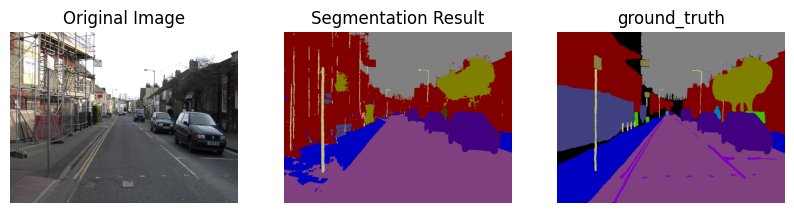

In [17]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from time import time
# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 载入模型
model = VGG16UNet(num_classes=11).to(device)
model.load_state_dict(torch.load("/home/sugon/zpy/U-NET/U-net/train_results/from100/vgg16_unet_epoch_375.pth", map_location=device))
model.eval()


# 预处理函数
transform = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 读取图片
image_path = "/home/sugon/zpy/U-NET/U-net/unet_data/test/Seq05VD_f05040.png"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # 增加batch维度

ground_truth_path = "/home/sugon/zpy/U-NET/U-net/unet_data/testannot/Seq05VD_f05040_L.png"
ground_truth = Image.open(ground_truth_path)

time1 = time()
# 进行推理
with torch.no_grad():
    output = model(input_tensor)
print(output.shape)

pred = output.detach().cpu().numpy() # detach(): 不需要梯度信息
pred_class = np.argmax(pred, axis=1)  # 沿类别维度取argmax
time2 = time()
print("pred cost: ", time2-time1)

colormap = [
    (128, 128, 128),  # Sky
    (128, 0, 0),      # Building
    (192, 192, 128),  # Column_Pole
    (128, 64, 128),   # Road
    (0, 0, 192),      # Sidewalk
    (128, 128, 0),    # Tree
    (64, 64, 128),    # Fence
    (64, 0, 128),     # Car
    (64, 64, 0),      # Pedestrian
    (0, 128, 192),    # Bicyclist
    (192, 128, 128)   # SignSymbol
]

h, w = pred_class.shape[-2:]
color_mask = np.zeros((h, w, 3), dtype=np.uint8)
for class_idx in range(len(colormap)):
    color_mask[pred_class[0] == class_idx] = colormap[class_idx]

# print(color_mask.shape)
plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(color_mask)
plt.title('Segmentation Result')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(ground_truth)
plt.title('ground_truth')
plt.axis('off')
plt.show()

In [47]:
a = torch.randn(11, 720, 960)
result = torch.argmax(a, dim=0).numpy()
print(result, result.shape)

[[ 3  4  2 ...  1  2  4]
 [ 8  1  6 ...  1  3  0]
 [ 3  1  8 ... 10  7  4]
 ...
 [10  7 10 ...  6  0  1]
 [ 3  7  1 ...  8  5  2]
 [ 1  9  3 ...  0  6  5]] (720, 960)


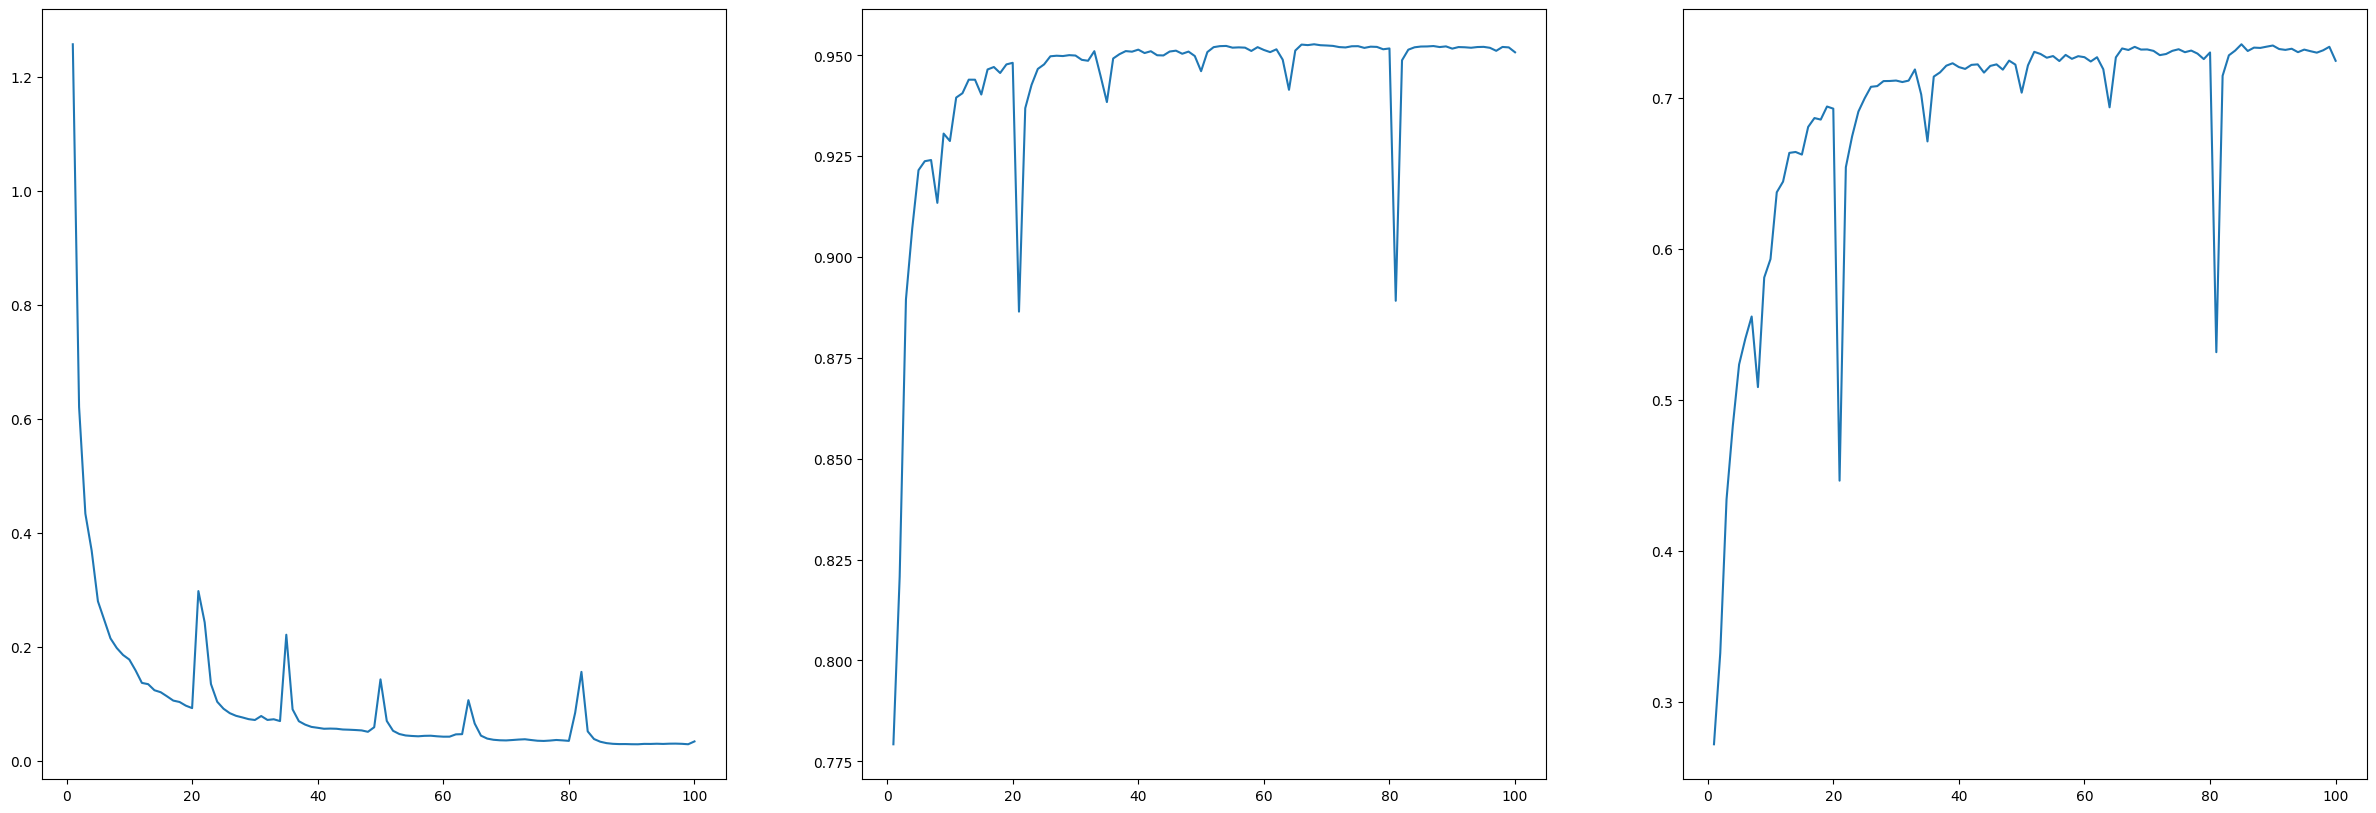

In [81]:
epochlist = [i for i in range(1, 101)]
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.plot(epochlist, loss_summary)
plt.subplot(1,3,2)
plt.plot(epochlist, accuracy_summary)
plt.subplot(1,3,3)
plt.plot(epochlist, iou_summary)



In [15]:
# 保存模型
save_dir = "/home/sugon/zpy/U-NET/U-net/train_results/from100/"
save_path = os.path.join(save_dir, f"vgg16_unet_epoch_{epoch+1}.pth")

torch.save(model.state_dict(), save_path)